In [1]:
# Description
"""
Eye Disease Classification — Testing Notebook (Cell-wise, simple)
- Framework: PyTorch
- Model: ResNet50 (custom final FC)
- What this notebook does:
1. Load the saved model
2. Pick a single image from a directory or list all images
3. Predict class + confidence
4. Produce Grad-CAM visual explanations


Paths (edit if needed):
- DATA_DIR: /kaggle/input/eye-disease-image-dataset/data/Augmented_Dataset
- MODEL_PATH: /kaggle/input/eyediseaseclassifier/pytorch/default/1/best_resnet50_model.pth


Note: The preprocessing MUST match the preprocessing used during training.
"""

'\nEye Disease Classification — Testing Notebook (Cell-wise, simple)\n- Framework: PyTorch\n- Model: ResNet50 (custom final FC)\n- What this notebook does:\n1. Load the saved model\n2. Pick a single image from a directory or list all images\n3. Predict class + confidence\n4. Produce Grad-CAM visual explanations\n\n\nPaths (edit if needed):\n- DATA_DIR: /kaggle/input/eye-disease-image-dataset/data/Augmented_Dataset\n- MODEL_PATH: /kaggle/input/eyediseaseclassifier/pytorch/default/1/best_resnet50_model.pth\n\n\nNote: The preprocessing MUST match the preprocessing used during training.\n'

In [2]:
# Imports
import os
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [3]:
# Config / Paths / Class names
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DATA_DIR = "/kaggle/input/eye-disease-image-dataset/data/Augmented_Dataset"
MODEL_PATH = "/kaggle/input/eyediseaseclassifier/pytorch/default/1/best_resnet50_model.pth"


CLASS_NAMES = [
"Central Serous Chorioretinopathy",
"Diabetic Retinopathy",
"Disc Edema",
"Glaucoma",
"Healthy",
"Macular Scar",
"Myopia",
"Pterygium",
"Retinal Detachment",
"Retinitis Pigmentosa",
]
NUM_CLASSES = len(CLASS_NAMES)


print(f"Device: {DEVICE}")
print(f"Model will be loaded from: {MODEL_PATH}")
print(f"Data directory: {DATA_DIR}")
print(f"Classes ({NUM_CLASSES}): {CLASS_NAMES}")

Device: cuda
Model will be loaded from: /kaggle/input/eyediseaseclassifier/pytorch/default/1/best_resnet50_model.pth
Data directory: /kaggle/input/eye-disease-image-dataset/data/Augmented_Dataset
Classes (10): ['Central Serous Chorioretinopathy', 'Diabetic Retinopathy', 'Disc Edema', 'Glaucoma', 'Healthy', 'Macular Scar', 'Myopia', 'Pterygium', 'Retinal Detachment', 'Retinitis Pigmentosa']


In [7]:
# Preprocessing (must match training)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


# Helper to convert tensor back to displayable image
def tensor_to_image(tensor):
    # De-normalize: (x * std) + mean  → here std=0.5, mean=0.5
    t = tensor.clone().cpu()
    t = t * 0.5 + 0.5
    t = t.permute(1, 2, 0).numpy()     # CHW → HWC
    t = np.clip(t * 255, 0, 255).astype(np.uint8)
    return t

In [9]:
def load_resnet50(model_path, num_classes, device=DEVICE):
    model = models.resnet50(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    state = torch.load(model_path, map_location=device)
    model.load_state_dict(state)

    model = model.to(device)
    model.eval()
    return model


# Load model
model = load_resnet50(MODEL_PATH, NUM_CLASSES)
print("Model loaded and set to eval()")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded and set to eval()


In [11]:
# Simple prediction utilities

def load_image(img_path):
    img = Image.open(img_path).convert('RGB')
    tensor = preprocess(img)
    return img, tensor


def predict_tensor(model, tensor):
    model.eval()
    with torch.no_grad():
        inp = tensor.unsqueeze(0).to(DEVICE)
        out = model(inp)
        probs = F.softmax(out, dim=1)
        conf, pred = torch.max(probs, dim=1)
        return pred.item(), conf.item(), probs.squeeze().cpu().numpy()

In [13]:
# Grad-CAM implementation (compact & robust)
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, class_idx):
        # input_tensor: 1,C,H,W on DEVICE
        self.model.zero_grad()
        output = self.model(input_tensor)
        if isinstance(output, tuple):
            output = output[0]
        loss = output[0, class_idx]
        loss.backward(retain_graph=True)

        grads = self.gradients  # B, C, H, W
        acts = self.activations  # B, C, H, W
        weights = grads.mean(dim=(2, 3), keepdim=True)  # B, C, 1, 1
        cam = (weights * acts).sum(dim=1, keepdim=True)  # B, 1, H, W
        cam = cam.squeeze().cpu().numpy()
        cam = np.maximum(cam, 0)
        if cam.max() != 0:
            cam = cam / cam.max()
        return cam

In [15]:
# Visualization helpers for Grad-CAM
def apply_colormap_on_image(org_img, activation_map, colormap=cv2.COLORMAP_JET, alpha=0.5):
    # org_img: HxWx3 uint8, activation_map: HxW normalized [0,1]
    heatmap = (activation_map * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(org_img, 1 - alpha, heatmap, alpha, 0)
    return overlay

In [17]:
# End-to-end single-image pipeline (predict + show + gradcam)
def run_on_image(img_path, model, class_names, show_gradcam=True, save_result=False, result_dir='results'):
    img, tensor = load_image(img_path)
    pred_idx, conf, probs = predict_tensor(model, tensor)
    pred_class = class_names[pred_idx]

    print(f"Image: {img_path}")
    print(f"Predicted: {pred_class} | Confidence: {conf*100:.2f}%")

    # show original image
    plt.figure(figsize=(5,5))
    plt.imshow(np.array(img))
    plt.title(f"Pred: {pred_class} ({conf*100:.2f}%)")
    plt.axis('off')
    plt.show()

    # Grad-CAM
    if show_gradcam:
        # Prepare input
        inp = tensor.unsqueeze(0).to(DEVICE)
        # Choose target layer - last block of layer4
        target_layer = model.layer4[-1]
        gradcam = GradCAM(model, target_layer)
        cam = gradcam.generate_cam(inp, pred_idx)
        cam_resized = cv2.resize(cam, (img.width, img.height))
        org_img = np.array(img.resize((img.width, img.height)))
        overlay = apply_colormap_on_image(org_img, cam_resized, alpha=0.45)

        plt.figure(figsize=(6,6))
        plt.imshow(overlay)
        plt.title(f"Grad-CAM — {pred_class} ({conf*100:.2f}%)")
        plt.axis('off')
        plt.show()

        if save_result:
            os.makedirs(result_dir, exist_ok=True)
            base = Path(img_path).stem
            out_path = os.path.join(result_dir, f"{base}_gradcam.png")
            cv2.imwrite(out_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
            print(f"Saved overlay to: {out_path}")

    return pred_idx, conf, probs

In [19]:
# Utility: show predictions for several images in a folder
def run_on_folder(folder_path, model, class_names, max_images=20, show_gradcam=False):
    imgs = [os.path.join(folder_path, f) for f in os.listdir(folder_path)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    imgs = sorted(imgs)[:max_images]
    results = []

    for p in imgs:
        pred_idx, conf, probs = run_on_image(p, model, class_names, show_gradcam=show_gradcam)
        results.append((p, class_names[pred_idx], conf))

    return results

Running demo on: /kaggle/input/eye-disease-image-dataset/data/Augmented_Dataset/Macular Scar/Macular Scar333.jpg
Image: /kaggle/input/eye-disease-image-dataset/data/Augmented_Dataset/Macular Scar/Macular Scar333.jpg
Predicted: Macular Scar | Confidence: 97.19%


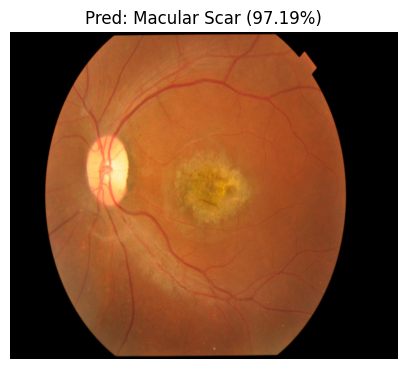

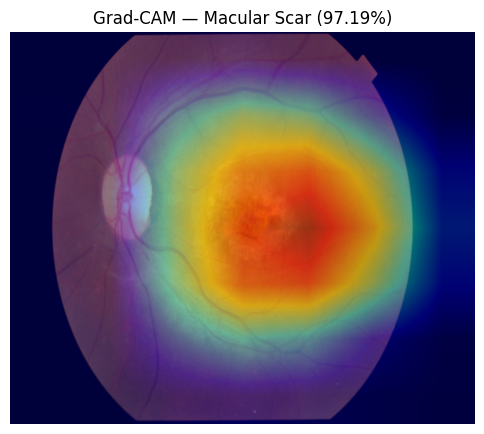

In [23]:
# Quick demo (edit path to point to any sample image inside DATA_DIR)
# Example usage: pick one image file from the dataset (replace the filename if needed)

sample_folder = DATA_DIR

# find a sample image automatically
found = None
for root, dirs, files in os.walk(sample_folder):
    for f in files:
        if f.lower().endswith(('.jpg', '.jpeg', '.png')):
            found = os.path.join(root, f)
            break
    if found:
        break

if found:
    print('Running demo on:', found)
    run_on_image(found, model, CLASS_NAMES, show_gradcam=True, save_result=False)
else:
    print('No image found in DATA_DIR. Please upload or point to an image file.')

Enter the full path of the image to test:  /kaggle/input/eye-disease-image-dataset/data/Augmented_Dataset/Healthy/Healthy1004.jpg


Running demo on: /kaggle/input/eye-disease-image-dataset/data/Augmented_Dataset/Healthy/Healthy1004.jpg
Image: /kaggle/input/eye-disease-image-dataset/data/Augmented_Dataset/Healthy/Healthy1004.jpg
Predicted: Glaucoma | Confidence: 73.42%


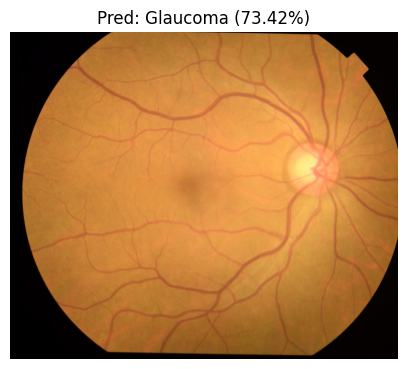

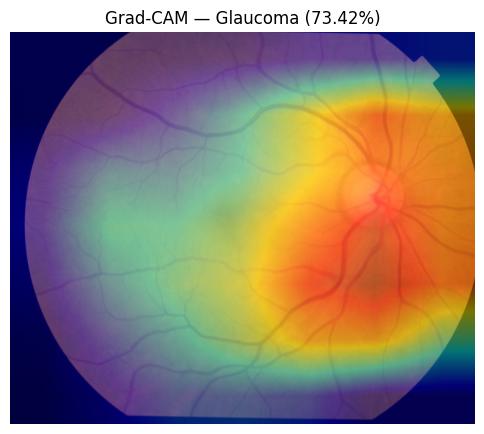

In [24]:
# Quick demo: manually choose an image file to test
# You can enter full path to any image you want to test
img_path = input("Enter the full path of the image to test: ").strip()

if os.path.isfile(img_path) and img_path.lower().endswith(('.jpg', '.jpeg', '.png')):
    print('Running demo on:', img_path)
    run_on_image(img_path, model, CLASS_NAMES, show_gradcam=True, save_result=False)
else:
    print('Invalid file path or unsupported image format. Please enter a valid image path ending with .jpg, .jpeg, or .png')

Enter the full path of the image to test:  /kaggle/input/eye-disease-image-dataset/data/Augmented_Dataset/Myopia/Myopia1001.jpg


Running demo on: /kaggle/input/eye-disease-image-dataset/data/Augmented_Dataset/Myopia/Myopia1001.jpg
Image: /kaggle/input/eye-disease-image-dataset/data/Augmented_Dataset/Myopia/Myopia1001.jpg
Predicted: Myopia | Confidence: 97.66%


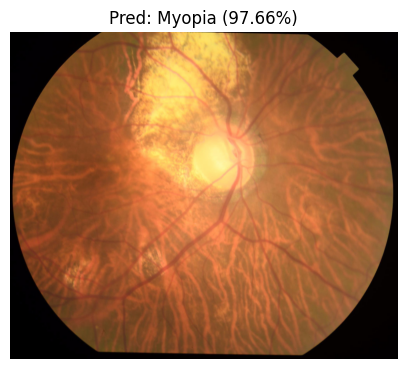

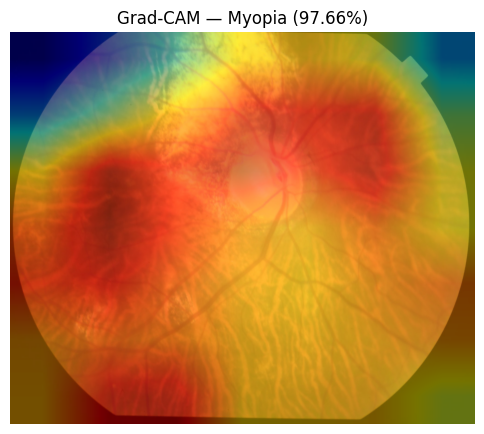

Actual Class: Myopia
Predicted: Myopia | Confidence: 97.66%


In [31]:
# Quick demo: manually choose an image file to test
img_path = input("Enter the full path of the image to test: ").strip()

if os.path.isfile(img_path) and img_path.lower().endswith(('.jpg', '.jpeg', '.png')):
    # Extract actual class from folder name
    true_class = Path(img_path).parent.name

    print('Running demo on:', img_path)
    pred_idx, conf, probs = run_on_image(img_path, model, CLASS_NAMES, show_gradcam=True, save_result=False)
    
    pred_class = CLASS_NAMES[pred_idx]
    print(f"Actual Class: {true_class}")
    print(f"Predicted: {pred_class} | Confidence: {conf*100:.2f}%")
else:
    print('Invalid file path or unsupported image format. Please enter a valid image path ending with .jpg, .jpeg, or .png')